In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Import DecisionTree as a classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
from sklearn.metrics import precision_score

In [35]:
path = '/home/malpizar/Documents/MultipleScattering/backup/'
file = 'RecoilsData.csv'

df = pd.read_csv(path + file)

#drop events with no recoils at all
df = df[df['ar40recoils'] != 0]

#drop rows with the value -99999, these are outliers
df = df.drop(index=df[df.eq(-99999).any(axis=1)].index)

df.head()
print(df.shape)

(1209, 25)


In [36]:
#drop the variable used to make the flags for multiple recoils
df = df.drop(['ar40recoils'], axis=1) 
print(df.shape)

(1209, 24)


In [37]:
# Count the occurrences of each value in multiplerecoils
value_counts = df['multiplerecoils'].value_counts()
print(value_counts)

1    934
0    275
Name: multiplerecoils, dtype: int64


In [38]:
# Drop rows with multiplerecoils to make it more even between multiple and single
df = df.drop(df[df['multiplerecoils'] == 1].head(650).index)

# Count the occurrences of each value in multiplerecoils again
value_counts = df['multiplerecoils'].value_counts()
print(value_counts)

1    284
0    275
Name: multiplerecoils, dtype: int64


In [39]:
#dependent variable that will be predicted
var = 'multiplerecoils'

X = df.drop([var], axis=1)

# Select the dependent variable
y = df[var] 

print(X.shape)
print(y.shape)

(559, 23)
(559,)


In [53]:
# Create the GradientBoostingClassifier (Boosted Decision Tree)
boosted_tree = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

print("Created Boosted Decision Tree Classifier")

Created Boosted Decision Tree Classifier


In [54]:
# Perform cross-validation with 10 folds
# 'cv' parameter specifies the number of folds
# 'scoring' parameter specifies the evaluation metric (e.g., 'accuracy')
cross_val_scores = cross_val_score(boosted_tree, X, y, cv=10, scoring='accuracy')

# Print the cross-validation scores for each fold
print("Cross-Validation Scores:")
for fold, score in enumerate(cross_val_scores, start=1):
    print(f"Fold {fold}: {score:.2f}")

# Calculate and print the average cross-validation score
average_score = cross_val_scores.mean()
print(f"\nAverage Score: {average_score:.2f}")

Cross-Validation Scores:
Fold 1: 0.66
Fold 2: 0.75
Fold 3: 0.59
Fold 4: 0.66
Fold 5: 0.84
Fold 6: 0.70
Fold 7: 0.71
Fold 8: 0.61
Fold 9: 0.68
Fold 10: 0.64

Average Score: 0.68


In [55]:
# Splitting the dataset to Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(447, 23)
(447,)
(112, 23)
(112,)


In [56]:
#Train DT
boosted_tree.fit(X_train, y_train)
print("Training set score: %f" % boosted_tree.score(X_train, y_train))
print("Test set score: %f" % boosted_tree.score(X_test, y_test))

Training set score: 0.950783
Test set score: 0.821429


In [57]:
# Make predictions on the test set
y_pred = boosted_tree.predict(X_test)

In [58]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.82143


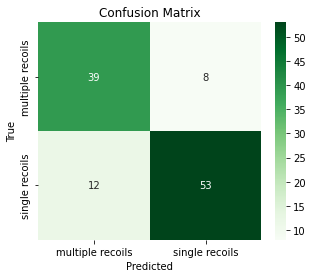

In [59]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
#class_labels = df[var].unique()
class_labels = ['multiple recoils', 'single recoils']

#print(df[var].unique())

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

# Add a legend
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [60]:
#calculate recall, precision and F1 score

rec = recall_score(y_test, y_pred, average='weighted')
pres = precision_score(y_test, y_pred, average='weighted')

F1_score = 2/((1/rec) + (1/pres))

print("The recall is: ", rec)
print("The precision is: ", pres)
print("The F1-score is: ", F1_score)

The recall is:  0.8214285714285714
The precision is:  0.8251480920236948
The F1-score is:  0.823284130636149


In [61]:
# Get the feature importances
importance = boosted_tree.feature_importances_

# Create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Sum all the importance values
total_importance = feature_importances_df.sum()
print("")
print(f"Total Importance: {total_importance}")

                   Feature  Importance
1                  fprompt    0.163276
5                   fmaxpe    0.141548
14          rprompt60Bayes    0.094174
13                nSCBayes    0.079803
17           mblikelihoodZ    0.059961
22                  deltat    0.050071
11   chargethirdbottomring    0.049678
9         chargebottomring    0.038771
0                      qPE    0.037570
3                eventTime    0.034318
15           mblikelihoodX    0.033711
20               timefit2Y    0.033521
18           mblikelihoodR    0.028648
16           mblikelihoodY    0.028445
21               timefit2Z    0.025619
19               timefit2X    0.024659
8         chargesecondring    0.021802
7            chargetopring    0.020886
10  chargesecondbottomring    0.018025
12      pulseindexfirstgar    0.014800
4           numEarlyPulses    0.000711
2                subeventN    0.000003
6                neckVetoN    0.000000

Total Importance: Feature       fpromptfmaxperprompt60BayesnSCB